In [3]:
import os
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
!pip install gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 18.9 MB/s eta 0:00:00


In [ ]:
# Function to evaluate keyframes
def evaluate_keyframes(keyframes, render=False, num_runs=3):
    """Simulates Walker2D using keyframes and returns the average reward over multiple runs."""
    env = gym.make("Walker2d-v5", render_mode=None)
    total_rewards = []

    for _ in range(num_runs):
        observation, info = env.reset(seed=42) # Reset environment before each run
        keyframe_index = 0
        remaining_steps = int(keyframes[keyframe_index][-1]) # Extract duration from the first keyframe
        episode_reward = 0

        while True:
            action = keyframes[keyframe_index][:-1]  # Extract the torque values (first 6 values)
            observation, reward, terminated, truncated, info = env.step(action) # Perform action
            episode_reward += reward # Accumulate reward

            if render:
                env.render()

            remaining_steps -= 1
            if remaining_steps == 0:
                keyframe_index = (keyframe_index + 1) % len(keyframes)
                remaining_steps = keyframes[keyframe_index][-1]

            if terminated or truncated:
                break

        total_rewards.append(episode_reward)

    env.close()
    return np.mean(total_rewards)  # Return average reward


In [5]:
# Function to generate random keyframes
def generate_random_keyframes(K=5):
    """Generates random keyframes with torque values and duration."""
    return [np.append(np.random.uniform(-1, 1, 6), np.random.randint(5, 50)) for _ in range(K)]


In [6]:
# Initialize population
def initialize_population(pop_size, K=5):
    return [generate_random_keyframes(K) for _ in range(pop_size)]

In [7]:
# Selection Methods
def tournament_selection(population, fitness_scores, k=3):
    """Selects a parent using tournament selection."""
    selected = random.sample(list(zip(population, fitness_scores)), k)
    return max(selected, key=lambda x: x[1])[0]  # Best in tournament

def roulette_wheel_selection(population, fitness_scores):
    """Selects a parent using roulette wheel selection."""
    fitness_scores = np.array(fitness_scores) - np.min(fitness_scores) + 1e-6  # Normalize
    selection_probs = fitness_scores / np.sum(fitness_scores)
    return population[np.random.choice(len(population), p=selection_probs)]

def rank_selection(population, fitness_scores):
    """Selects a parent using rank-based selection."""
    sorted_pop = [x for _, x in sorted(zip(fitness_scores, population))]
    rank_probs = np.linspace(0, 1, len(sorted_pop))
    rank_probs /= np.sum(rank_probs)
    return sorted_pop[np.random.choice(len(sorted_pop), p=rank_probs)]


In [12]:
def crossover(parent1, parent2):
    """Performs uniform crossover for each keyframe between two parents."""
    child = []
    for kf1, kf2 in zip(parent1, parent2):
        mask = np.random.rand(len(kf1)) < 0.5  # Create a mask for each keyframe
        child_kf = np.where(mask, kf1, kf2)  # Apply crossover
        child.append(child_kf)
    return child

# Mutation
def mutate(keyframes, mutation_rate=0.1):
    """Mutates keyframes by applying small Gaussian noise."""
    for keyframe in keyframes:
        if np.random.rand() < mutation_rate:
            mutation_index = np.random.randint(6)  # Select parameter to mutate
            keyframe[mutation_index] += np.random.normal(0, 0.1)  # Small change
    return keyframes

In [ ]:
def evolutionary_optimization(pop_size, generations, mutation_rate, crossover_rate, keyframe_count, tournament_size, step_limit, elite_count, stagnation_limit, selection_strategy):
    population = initialize_population(pop_size, keyframe_count)
    best_fitness_over_generations = []

    for generation in range(generations):
        fitness_scores = [evaluate_keyframes(ind) for ind in population]

        best_fitness = max(fitness_scores)
        best_fitness_over_generations.append(best_fitness)
        print(f"Generation {generation}: Best Reward = {best_fitness}")

        new_population = []
        for _ in range(pop_size // 2):
            if selection_strategy == "tournament": 
                parent1 = tournament_selection(population, fitness_scores, tournament_size) 
                parent2 = tournament_selection(population, fitness_scores, tournament_size)
            elif selection_strategy == "roulette":
                parent1 = roulette_wheel_selection(population, fitness_scores) 
                parent2 = roulette_wheel_selection(population, fitness_scores)
            elif selection_strategy == "rank":
                parent1 = rank_selection(population, fitness_scores) 
                parent2 = rank_selection(population, fitness_scores)
            else:
                raise ValueError("Invalid selection strategy")

            if np.random.rand() < crossover_rate:
                child1 = mutate(crossover(parent1, parent2), mutation_rate) 
                child2 = mutate(crossover(parent2, parent1), mutation_rate) 
            else:
                child1, child2 = parent1, parent2

            new_population.extend([child1, child2])

        population = new_population # Replace old population

    best_solution = population[np.argmax(fitness_scores)]
    return best_solution, best_fitness_over_generations

Generation 0: Best Reward = 82.55626391462698
Generation 1: Best Reward = 67.6562703143354
Generation 2: Best Reward = 80.69187827225171
Generation 3: Best Reward = 57.39069886239901
Generation 4: Best Reward = 64.2088387423716
Generation 5: Best Reward = 113.39143115619181
Generation 6: Best Reward = 107.46644763769105
Generation 7: Best Reward = 127.95650537715363
Generation 8: Best Reward = 173.6481744796637
Generation 9: Best Reward = 150.6502651514782
Generation 10: Best Reward = 163.4345043137843
Generation 11: Best Reward = 163.89437708260343
Generation 12: Best Reward = 138.92274759602833
Generation 13: Best Reward = 134.54654165163748
Generation 14: Best Reward = 221.47145265775478
Generation 15: Best Reward = 289.2145535120908
Generation 16: Best Reward = 169.37385900049938
Generation 17: Best Reward = 180.68659492113377
Generation 18: Best Reward = 484.8393424876021
Generation 19: Best Reward = 255.8834464403961
Generation 20: Best Reward = 318.66166503197314
Generation 21: 

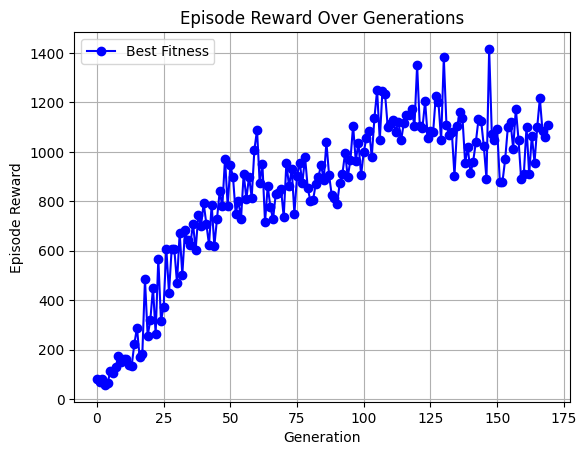

In [ ]:
# Main function
def main():
    best_keyframes, fitness_over_generations = evolutionary_optimization(
        pop_size=100,
        generations=170,
        mutation_rate=0.125,
        crossover_rate=0.9,
        keyframe_count=6,
        tournament_size=12,
        step_limit=6000,
        elite_count=50,
        stagnation_limit=50,
        selection_strategy="roulette"
    )

    # Display best keyframes
    print("\nBest keyframes obtained:", best_keyframes)

   # Test best keyframes multiple times to reduce randomness
    num_tests = 5
    test_rewards = [evaluate_keyframes(best_keyframes) for _ in range(num_tests)]
    avg_reward = np.mean(test_rewards)

    print(f"Final Reward of Best Solution (Average over {num_tests} runs): {avg_reward}")


    # Save best keyframes
    with open("best_keyframes.txt", "w") as f:
        f.write(f"{len(best_keyframes)}\n")
        for keyframe in best_keyframes:
            f.write(", ".join(map(str, keyframe)) + "\n")

    # Plot episode reward over generations
    plt.plot(fitness_over_generations, label="Best Fitness", color="blue", linestyle="-", marker="o")
    plt.xlabel("Generation")
    plt.ylabel("Episode Reward")
    plt.title("Episode Reward Over Generations")
    plt.legend()
    plt.grid()
    plt.show()


main()